# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Group Project -- Final Deliverables
**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>

**Paper Name: Distilling the Knowledge in a Neural Network**<br>
**Paper URL: https://arxiv.org/abs/1503.02531**

**Team name: ENSEMBLE**<br>
**Team members:**<br>
-- Timothy Lee (lee709@g.harvard.edu)

-- Shiyun Qiu (shiyunqiu@g.harvard.edu)

-- Xiangru Shu (xiangru_shu@g.harvard.edu)

-- Yuyue Wang (yuyue_wang@g.harvard.edu)

---

## Background Information

For large-scale machine learning tasks, such as speech and object recognition, a cumbersome model is commonly used to acheive high accuracy. The cumbersome model could be an ensemble of smaller models or a single large model trained with a strong regularizer. However, it is impractical to deploy the cumbersome model to a large number of users due to limited computational resources. One solution to this problem is to transfer the knowledge from the cumbersome model to a small model more suitable for deployment through "distillation".

When we are distilling the knowledge of a cumbersome model into a small model, we should train the small model to generalize in the same way as the cumbersome model so that the small model can generalize well to new data. One way to transfer the generalization ability is to use the class probabilities produced by the cumbersome model as "soft targets" when training the small model. When the large model is an ensemble of simpler models, we can take an arithmetic or geometric mean of the predictive distributions as the soft targets. As these soft targets contain probabilities of all incorrect classes in addition to the probability of the correct class, we can obtain a lot of information about how the large model generalizes from the relative probabilites in each training case. Soft targets with high entropy have much less variance in the gradient between training cases, so we can train the small model with less data and a higher learning rate.

---

## Summary of Methods

### Distillation

#### Class Probability
For neural networks, the class probabilities, $q_i$ are usually computed through the softmax output layer,
$$ q_i = \frac{\exp\{z_i/T\}}{\Sigma_j\exp\{z_j/T\}},$$
where $z_i$'s are the logits, i.e. the vector of raw (non-normalized) predictions that a classification model generates, and T is a temperature which is normally set to 1. Higher temperature leads to similar class probabilities (similar $q_i$ values), so it produces a softer probability distribution over classes. 

#### Simplest Form of Distillation 
The distilled model will be trained on a transfer set. Each training case in the transfer set is a soft target distribution produced by the cumbersome model with a high temperature in its softmax. We will use the same high temperature to train the distilled model. After the model is trained, we will use a temperature of 1 to predict.

#### Correct Labels Partially Known for the Transfer Set
Two objective functions are needed.

Objective function 1: cross entropy with the soft targets.<br>
We need to use the same high temperature used to train the cumbersome model in the softmax of the distilled model. 

Objective function 2: cross entropy with the correct labels.<br>
We need to use the same logits in softmax of the distilled model but at a temperature of 1.

$$ \mathcal{L}(x; W) = \alpha * \mathcal{H}(\sigma(z_c/\tau), \sigma(z_d/\tau)) + \beta * \mathcal{H}(y, \sigma(z_d)), $$
where x is the input, W is the model parameters in the distilled model, $\mathcal{H}$ is the cross entropy function, $\sigma$ is the softmax function, $\tau$ is the temperature used to train the cumbersome model, $z_c$ is the logit of the cumbersome model, $z_d$ is the logit of the distilled model, and $\alpha$ and $\beta$ are the weights ($\beta=1-\alpha$).

A weighted average of these two objective functions will be computed with a considerably lower weight placed on the second one (i.e. significantly smaller $\beta$). 

The magnitudes of the graidents of soft targets scale as $1/T^2$. To prevent the relative contributions of the hard and soft targets from changing when we adjust meta-parameters, we will multiply both of them by $T^2$.


### Digit Matching as Special Case of Distillation

Previous work by Caruana and his collaborators used logits produced by the softmax as the targets for training the small model by minimizing the squared difference between the logits produced by the cumbersome model and those produced by the small model. In this section, we will show that matching the logits is indeed a special case of distillation.

The cross-entropy with the soft targets for each class $i$ can be computed as the following,
$$ 
\begin{align}
\mathcal{H}(\sigma(z_{ci}/\tau), \sigma(z_{di}/\tau)) 
&= - \frac{\exp\{z_{ci}/\tau\}}{\Sigma_j\exp\{z_{cj}/\tau\}} * \log (\frac{\exp\{z_{di}/\tau\}}{\Sigma_j\exp\{z_{dj}/\tau\}})\\
&= - \frac{\exp\{z_{ci}/\tau\}}{\Sigma_j\exp\{z_{cj}/\tau\}} * (z_{di}/\tau - 
\log (\Sigma_j\exp\{z_{dj}/\tau\})).\\
\end{align}
$$

Taking gradient of the cross-entropy with respect to $z_{di}$ gives us,
$$
\begin{align}
\frac{\partial \mathcal{H}(\sigma(z_{ci}/\tau), \sigma(z_{di}/\tau))}{\partial z_{di}}
&= \frac{1}{\tau}(\frac{\exp\{z_{di}/\tau\}}{\Sigma_j\exp\{z_{dj}/\tau\}} - \frac{\exp\{z_{ci}/\tau\}}{\Sigma_j\exp\{z_{cj}/\tau\}}).
\end{align}
$$

When the temperature $\tau$ is high compared with the magnitude of the logits, we can approximate $\exp\{z_{i}/\tau\}$ through taylor expansion, i.e. $\exp\{z_{i}/\tau\} \approx 1+z_{i}/\tau$. So the gradient can be estimated as following,
$$
\begin{align}
\frac{\partial \mathcal{H}(\sigma(z_{ci}/\tau), \sigma(z_{di}/\tau))}{\partial z_{di}}
&\approx \frac{1}{\tau}(\frac{1+z_{di}/\tau}{N+\Sigma_j z_{dj}/\tau} - \frac{1+z_{ci}/\tau}{N+\Sigma_j z_{cj}/\tau}),
\end{align}
$$
where N is the number of total classes.

When the logits are zero-meaned for each transfer case, i.e. $\Sigma_j z_{dj} = \Sigma_j z_{cj} = 0$, the gradient can be simplified to 
$$
\begin{align}
\frac{\partial \mathcal{H}(\sigma(z_{ci}/\tau), \sigma(z_{di}/\tau))}{\partial z_{di}}
&\approx \frac{1}{\tau}(\frac{1+z_{di}/\tau}{N} - \frac{1+z_{ci}/\tau}{N})\\
&\approx \frac{1}{N\tau^2}(z_{di} - z_{ci}).\\
\end{align}
$$

So when the temperature is high, distillation is also minimizing $\frac{1}{2}(z_{di} - z_{ci})$, the squared difference between the logits produced by the cumbersome model and those produced by the small model.

---

## Python Reimplementation

### MNIST

### CIFAR-10

#### Generalist Model

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd.variable as Variable
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.cluster import KMeans
from tqdm import tqdm_notebook as tqdm
import collections
%matplotlib inline

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size =4

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)



Files already downloaded and verified


In [19]:
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = [' ']*100
class_num = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

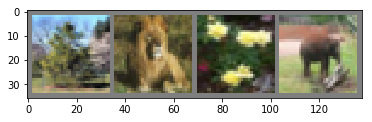

In [20]:

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [21]:

class Net(nn.Module):
    def __init__(self,class_num=10):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, class_num)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
    
generalist_net = Net(class_num=class_num)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(generalist_net.parameters(), lr=0.001, momentum=0.9)

In [23]:
for epoch in range(5):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for data in tqdm(trainloader,desc='epoch '+str(epoch+1)):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = generalist_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
#         if i % 4000 == 3999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0
    print('loss:',running_loss/len(trainloader))
print('Finished Training')

loss: 4.1690870308208465


loss: 3.5994321661281585


loss: 3.330149893140793


loss: 3.1707751224660874


loss: 3.0574880642986297
Finished Training


GroundTruth:                         


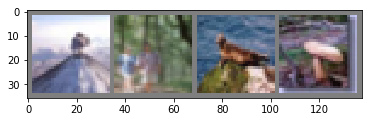

In [24]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [25]:
outputs = generalist_net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:                         


In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = generalist_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 24 %


In [27]:
class_correct = list(0. for i in range(class_num))
class_total = list(0. for i in range(class_num))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = generalist_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(class_num):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of       : 45 %
Accuracy of       : 22 %
Accuracy of       : 21 %
Accuracy of       :  4 %
Accuracy of       :  3 %
Accuracy of       :  6 %
Accuracy of       : 15 %
Accuracy of       : 24 %
Accuracy of       : 22 %
Accuracy of       : 34 %
Accuracy of       :  9 %
Accuracy of       :  7 %
Accuracy of       : 15 %
Accuracy of       : 12 %
Accuracy of       : 24 %
Accuracy of       :  7 %
Accuracy of       : 23 %
Accuracy of       : 36 %
Accuracy of       : 44 %
Accuracy of       : 10 %
Accuracy of       : 56 %
Accuracy of       : 51 %
Accuracy of       : 17 %
Accuracy of       : 59 %
Accuracy of       : 58 %
Accuracy of       :  8 %
Accuracy of       :  4 %
Accuracy of       : 27 %
Accuracy of       : 37 %
Accuracy of       : 15 %
Accuracy of       : 25 %
Accuracy of       : 19 %
Accuracy of       : 11 %
Accuracy of       : 33 %
Accuracy of       : 11 %
Accuracy of       :  2 %
Accuracy of       : 25 %
Accuracy of       :  9 %
Accuracy of       : 16 %
Accuracy of       : 13 %


##### Assign classes to specialists using Kmeans

In [28]:
cluster_num = 4

all_output = []
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = generalist_net(images)
        all_output.append(outputs)
all_output = torch.cat(all_output)

# print(all_output.shape)

img = all_output.detach().numpy().transpose()
# print(img.shape)
cov_pred = np.cov(img)
kmeans = KMeans(n_clusters=cluster_num).fit(cov_pred)
print(kmeans.labels_)

[3 3 3 2 2 1 3 3 1 3 3 3 0 1 3 2 3 0 2 2 3 2 3 0 3 1 3 2 3 2 0 2 1 1 3 3 3
 1 2 1 3 3 2 3 2 3 3 1 1 0 2 3 0 3 3 2 0 3 1 0 0 3 3 2 2 2 2 0 0 0 3 0 2 0
 2 2 0 2 3 2 2 1 3 3 3 0 3 1 3 1 1 1 3 2 3 0 0 2 3 3]


In [29]:
label_to_cluster = collections.defaultdict()
cluster_to_label = collections.defaultdict(list)
for original_label, cluster in enumerate(kmeans.labels_):
    label_to_cluster[original_label] = cluster
    cluster_to_label[cluster].append(original_label)

In [30]:
cluster_to_label

defaultdict(list,
            {3: [0,
              1,
              2,
              6,
              7,
              9,
              10,
              11,
              14,
              16,
              20,
              22,
              24,
              26,
              28,
              34,
              35,
              36,
              40,
              41,
              43,
              45,
              46,
              51,
              53,
              54,
              57,
              61,
              62,
              70,
              78,
              82,
              83,
              84,
              86,
              88,
              92,
              94,
              98,
              99],
             2: [3,
              4,
              15,
              18,
              19,
              21,
              27,
              29,
              31,
              38,
              42,
              44,
              50,
              55,
           

In [31]:
specialists_trainsets = collections.defaultdict(list)
specialists_dustbin_from = collections.defaultdict(list)
                     
for i,data in enumerate(trainset,0):
    image, label = data
    cluster = label_to_cluster[label]
    specialists_trainsets[cluster].append((image, cluster_to_label[cluster].index(label)))
    for c in range(cluster_num):
        if c != cluster:
            specialists_dustbin_from[c].append(i)

In [32]:
class SpecialistNet(nn.Module):
    def __init__(self,specialist_class_num):
        super(SpecialistNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, specialist_class_num)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    

##### Train Specialists

In [33]:
specialist_models = collections.defaultdict()

In [34]:
for cluster in range(cluster_num):
    specialist_dustbin_indices = np.random.choice(len(specialists_dustbin_from[cluster]),
                                                  len(specialists_trainsets[cluster]),
                                                  replace=False)
    dustbin_indices = [specialists_dustbin_from[cluster][i] for i in specialist_dustbin_indices]
    sampler = SubsetRandomSampler(dustbin_indices)
    specialist_dustbin = torch.utils.data.DataLoader(trainset, sampler = sampler,num_workers=2)
    
    # relabel specialist trainset and dustbin
    specialist_dustbin = [(data[0][0],len(cluster_to_label[cluster])) for data in specialist_dustbin]
    
    specialist_trainset_full = specialists_trainsets[cluster] + specialist_dustbin
#     print(len(specialist_trainset_full))
    
    specialist_trainloader = torch.utils.data.DataLoader(specialist_trainset_full, batch_size=4,
                                          shuffle=True, num_workers=2)
    
    
    specialist_net = SpecialistNet(specialist_class_num=len(cluster_to_label[cluster])+1)
    
    specialist_net.conv1.weight.data = generalist_net.conv1.weight
    specialist_net.conv2.weight.data = generalist_net.conv2.weight
    specialist_net.fc1.weight.data = generalist_net.fc1.weight
    specialist_net.fc2.weight.data = generalist_net.fc2.weight
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(specialist_net.parameters(), lr=0.001, momentum=0.9)
    
    
    for epoch in range(5):  # loop over the dataset multiple times

        running_loss = 0.0
        for data in tqdm(specialist_trainloader,desc='epoch '+str(epoch+1)):
            # get the inputs
            inputs, labels = data

    #         print(inputs, labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = specialist_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
#             if i % 2000 == 1999:    # print every 2000 mini-batches
#                 print('[%d, %5d] loss: %.3f' %
#                       (epoch + 1, i + 1, running_loss / 2000))
#                 running_loss = 0.0
        print('loss:',running_loss/len(specialist_trainloader))
    print('\nFinished Training Cluster #',str(cluster))
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in specialist_trainloader:
            images, labels = data
            outputs = specialist_net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of specialist # '+str(cluster)+' on training set: '
          +str(100 * correct / total)+'%')
    
    specialist_models[cluster] = specialist_net

loss: 1.2319106579158041


loss: 1.0511562505430645


loss: 0.9776741216712528


loss: 0.9207407252258725


loss: 0.8763322533435292

Finished Training Cluster # 0
Accuracy of specialist # 0 on training set: 72.83888888888889%


loss: 1.565105987548828


loss: 1.3402041165456176


loss: 1.2417551368400455


loss: 1.1679255098924042


loss: 1.0984917037189006

Finished Training Cluster # 1
Accuracy of specialist # 1 on training set: 70.0875%


loss: 1.9742311274546844


loss: 1.7785099202577885


loss: 1.687916194659013


loss: 1.6180490029775179


loss: 1.5601374145058484

Finished Training Cluster # 2
Accuracy of specialist # 2 on training set: 58.738461538461536%


loss: 1.9777923901498318


loss: 1.7240972446799279


loss: 1.6254383429646493


loss: 1.554765300154686


loss: 1.5032051890432834

Finished Training Cluster # 3
Accuracy of specialist # 3 on training set: 61.3575%


## Inference / Test



### Step 1 & 2

For each test case, we find the n most probable classes according to the generalist model.
Call this set of classes k. In our experiments, we used n = 1.

In [35]:
def specialist_result_expansion(specialist,specialist_result,class_num):
    expanded = torch.zeros(class_num)
    specialist_member_num = len(specialist)-1
    for i in range(class_num):
        if i in specialist:
            expanded[i] = specialist_result[specialist.index(i)]
        else:
            expanded[i] = specialist_result[-1] / (class_num-specialist_member_num)
    return expanded
            

In [38]:
# compute p_g, p_m, and perform GD to find q

total = 0
correct = 0

total_gen = 0
correct_gen = 0

n = 3 # consider top n probable classes from generalist model


with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = generalist_net(images)
        
        # z distribution, label for a batch
        _, predicted = torch.max(outputs.data, 1)
        topn_z,topn_predicted = torch.topk(outputs,n)
        
        
        
        # probability distribution for a batch
        p_g = F.softmax(outputs, dim = 0)
        for i in range(batch_size):
            topn_sum = []
            for j in range(n):
                generalist_label = topn_predicted[i][j]
#                 generalist_label = predicted[i]
                cluster = label_to_cluster[int(generalist_label)]
                specialist_net = specialist_models[int(cluster)]
                specialist_outputs = specialist_net(images)
#                 pg_i = outputs[i] # z
#                 pm_i = specialist_outputs[i] #z
                
                pg_i = p_g[i] #softmax
                pm_i = F.softmax(specialist_outputs[i],dim=0) #softmax
                
                expanded_pm_i = specialist_result_expansion(cluster_to_label[cluster],pm_i,class_num=class_num)
                topn_sum.append(expanded_pm_i.numpy())
#             q_hat=np.mean([pg_i.numpy(),expanded_pm_i.numpy()],axis=0)
            q_hat = np.mean([pg_i.numpy()]+topn_sum,axis=0)
#             q_hat = F.softmax(torch.Tensor(q_hat),dim=0)
#             q_hat = expanded_pm_i
            label = np.argmax(q_hat)

            total += 1
            if label == labels[i]:
                correct += 1


        total_gen += labels.size(0)
        correct_gen += (predicted == labels).sum().item()
        

In [39]:
print("test accuracy of generalist: ", 100*correct_gen/total_gen,'%')
print("test accuracy of ensemble: ", 100*correct/total,'%')

test accuracy of generalist:  12.7 %
test accuracy of ensemble:  15.64 %


In [ ]:
def resize_q(P_g,q,P_m):
    # q should have size same as P_g(10)
    # need to sum all dustbin class probabilities into one
    
    if len(P_m) == len(animals)+1:
        q_resize = torch.zeros(len(animals)+1,dtype=torch.float)
        for i,index in enumerate(animals):
            q_resize[i] = q[index]
        for j,index in enumerate(transportation):
            q_resize[-1] += q[index]
    elif len(P_m) == len(transportation)+1:
        q_resize = torch.zeros(len(transportation)+1,dtype=torch.float)
        for i,index in enumerate(transportation):
            q_resize[i] = q[index]
        for j,index in enumerate(animals):
            q_resize[-1] += q[index]
    return q_resize

In [ ]:
def KL_loss(P_g,q,P_m,q_resize):
    return F.kl_div(P_g,q) + F.kl_div(P_m,q_resize)

In [ ]:
def KL_gradient(P_g,P_m,q,q_resize,special_list,num_class = 10):
    # make sure P_q, P_m, and q are all Tensors
    gradient_Pg = - P_g / q
    q_dustbin = 0
    # calculate q_dustbin
    for i in range(num_class):
        if i not in special_list:
            q_dustbin += q[i]
    gradient_Pm = torch.zeros(num_class)
    for i in range(num_class):
        if i in special_list:
            gradient_Pm[i] = -P_m[special_list.index(i)]/q[i]
        else:
            gradient_Pm[i] = -P_m[-1]/q_dustbin
    return gradient_Pg + gradient_Pm

In [ ]:
def minimization(P_g,P_m,num_epoch):
    
    if len(P_m) == len(animals)+1:
        special_list = animals
    elif len(P_m) == len(transportation)+1:
        special_list = transportation
    
    gamma = 0.01 # step size
    
    
    
    q = Variable(np.random.rand(10),dtype = torch.float, requires_grad=True) # random initialize q
#     print('random q:',q)
    q_resize = resize_q(P_g,q,P_m)
    
    for epoch in range(num_epoch):
        loss = KL_loss(P_g,q,P_m,q_resize)
#         print('LOSS:',loss)
        q -= gamma * KL_gradient(P_g,P_m,q,q_resize,special_list)
        
#         print('updated? q:',q)
    return q

## Analysis and Comparison